Starting hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 160 candidates, totalling 800 fits


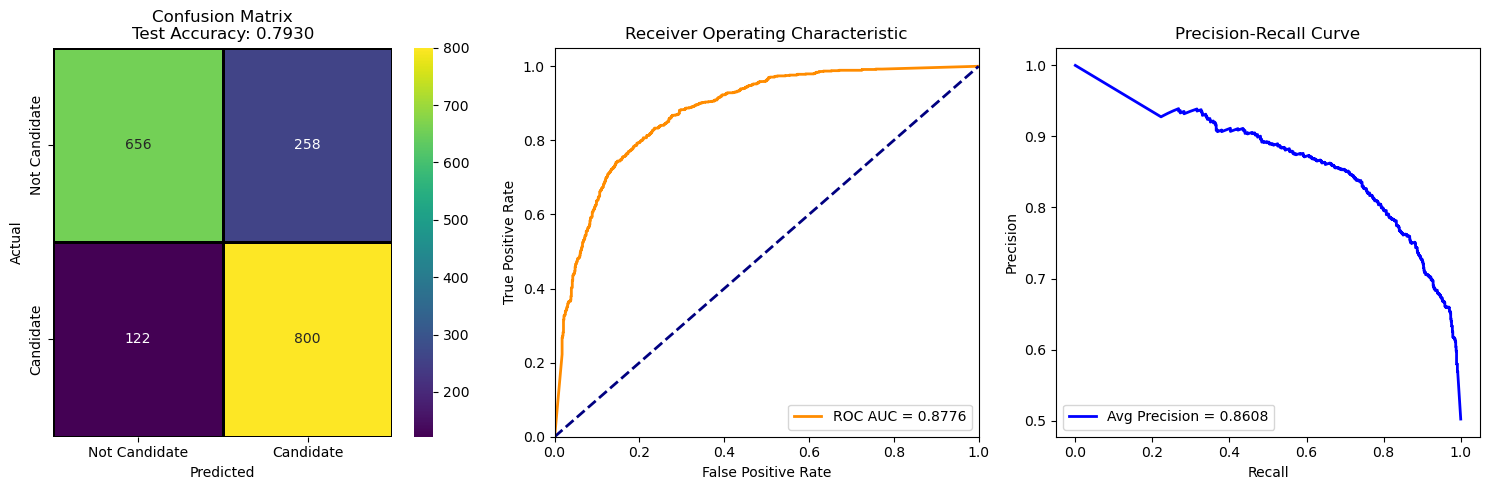


=== Best Model Summary ===
Best Parameters: {'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 14, 'weights': 'distance'}
Cross-Validation Accuracy: 0.7859
Test Accuracy: 0.7930
ROC AUC Score: 0.8776
Average Precision Score: 0.8608

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.72      0.78       914
           1       0.76      0.87      0.81       922

    accuracy                           0.79      1836
   macro avg       0.80      0.79      0.79      1836
weighted avg       0.80      0.79      0.79      1836



In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess data
short_cols = ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad',
              'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smet', 'ExoplanetCandidate']

data = pd.read_csv('KOI_cumulative_2025.07.31_21.17.09.csv', comment='#')
data['ExoplanetCandidate'] = data['koi_pdisposition'].apply(lambda x: 1 if x == 'CANDIDATE' else 0)
data = data[short_cols].dropna()
data.to_csv('KOI_2025.07.31_cleaned.csv', index=False)

# Prepare features and target
X = data.drop(columns=['ExoplanetCandidate'])
y = data['ExoplanetCandidate']

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2, stratify=y)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
joblib.dump(scaler, 'scaler_ksmet.sav')

# Set up parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': range(10, 30, 2),
    'leaf_size': [10, 20, 30, 40],
    'weights': ['uniform', 'distance'],
    'metric': ['manhattan', 'euclidean']
}

# Initialize and fit GridSearchCV
print("Starting hyperparameter tuning with GridSearchCV...")
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Save results and model
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.to_csv('KNN_hyperparameter_tuning_results.csv', index=False)
joblib.dump(best_model, 'best_tuned_knn_model.sav')

# Evaluate on test set
test_score = best_model.score(X_test, y_test)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Generate evaluation plots
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="viridis", fmt="d", 
            linecolor="k", linewidths=1,
            xticklabels=['Not Candidate', 'Candidate'],
            yticklabels=['Not Candidate', 'Candidate'])
plt.title(f"Confusion Matrix\nTest Accuracy: {test_score:.4f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
plt.plot(recall, precision, color='blue', lw=2, 
         label=f'Avg Precision = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig('KNN_model_evaluation.png')
plt.show()

# Print final model summary
print("\n=== Best Model Summary ===")
print(f"Best Parameters: {best_params}")
print(f"Cross-Validation Accuracy: {best_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Top Performing Configuration:
 param_leaf_size param_metric  param_n_neighbors param_weights  mean_test_score
              10    manhattan                 14      distance         0.785891


C:\Users\huangm\AppData\Local\Temp\ipykernel_13076\1970568255.py:108: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


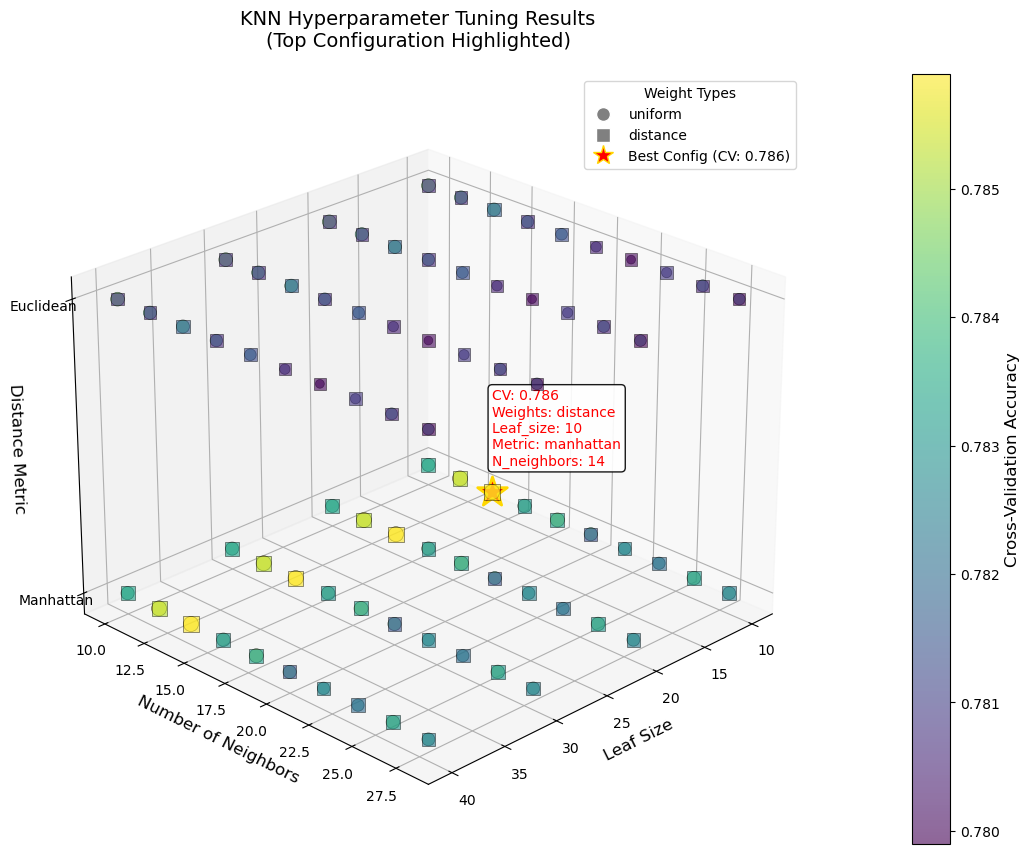

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.lines import Line2D

# Load data
df = pd.read_csv('KNN_hyperparameter_tuning_results.csv')

# Get top 1 configuration
top1 = df.nlargest(1, 'mean_test_score')
print("Top Performing Configuration:")
print(top1[['param_leaf_size', 'param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_score']].to_string(index=False))

# Map weights to shapes and colors
weights_mapping = {
    'uniform': {'marker': 'o', 'color': '#1f77b4'},
    'distance': {'marker': 's', 'color': '#ff7f0e'},
}

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot all points (colored by CV score)
for weight_type, props in weights_mapping.items():
    mask = df['param_weights'] == weight_type
    sc = ax.scatter(
        df.loc[mask, 'param_leaf_size'],
        df.loc[mask, 'param_n_neighbors'],  # Swapped metric and n_neighbors for better visualization
        [0 if m == 'manhattan' else 1 for m in df.loc[mask, 'param_metric']],  # Convert metric to numerical
        c=df.loc[mask, 'mean_test_score'],
        cmap='viridis',
        marker=props['marker'],
        s=40 + 80*(df.loc[mask, 'mean_test_score'] - df['mean_test_score'].min())/(df['mean_test_score'].max() - df['mean_test_score'].min()),
        alpha=0.6,
        edgecolor='k',
        linewidth=0.5,
        label=weight_type
    )

# Highlight ONLY the top 1 point in red
ax.scatter(
    top1['param_leaf_size'],
    top1['param_n_neighbors'],
    [0 if m == 'manhattan' else 1 for m in top1['param_metric']],
    c='red',
    marker='*',
    s=500,
    edgecolor='gold',
    linewidth=2,
    alpha=1,
    label=f'Best (CV: {top1["mean_test_score"].values[0]:.3f})',
    zorder=10
)

# Add detailed label to top point
ax.text(top1['param_leaf_size'].values[0], 
        top1['param_n_neighbors'].values[0], 
        [0 if m == 'manhattan' else 1 for m in top1['param_metric']][0] + 0.1,
        f"CV: {top1['mean_test_score'].values[0]:.3f}\n"
        f"Weights: {top1['param_weights'].values[0]}\n"
        f"Leaf_size: {top1['param_leaf_size'].values[0]}\n"
        f"Metric: {top1['param_metric'].values[0]}\n"
        f"N_neighbors: {top1['param_n_neighbors'].values[0]}",
        color='red',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round'))

# Colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Cross-Validation Accuracy', fontsize=12)

# Custom legend
legend_elements = [
    *[Line2D([0], [0],
             marker=props['marker'],
             color='w',
             markerfacecolor='gray',
             markersize=10,
             label=weight_type) for weight_type, props in weights_mapping.items()],
    Line2D([0], [0],
           marker='*',
           color='w',
           markerfacecolor='red',
           markeredgecolor='gold',
           markersize=15,
           label=f'Best Config (CV: {top1["mean_test_score"].values[0]:.3f})')
]

ax.legend(handles=legend_elements, title='Weight Types', loc='upper right')

# Axis labels and ticks
ax.set_xlabel('Leaf Size', fontsize=12)
ax.set_ylabel('Number of Neighbors', fontsize=12)
ax.set_zlabel('Distance Metric', fontsize=12)

# Set custom z-axis ticks for metric
ax.set_zticks([0, 1])
ax.set_zticklabels(['Manhattan', 'Euclidean'])

# Title
plt.title('KNN Hyperparameter Tuning Results\n(Top Configuration Highlighted)', 
          fontsize=14, pad=20)

# Adjust view
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.savefig('KNN_Top1_Configuration.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Feature importance (permutation importance)
from sklearn.inspection import permutation_importance

print("\nCalculating feature importance...")
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, color='skyblue')
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('KNN_feature_importance.png')
plt.show()